## Introduction

In this notebook, we will learn how to use [LoRA](https://arxiv.org/abs/2106.09685) from 🤗 PEFT to fine-tune an image classification model by ONLY using **0.77%** of the original trainable parameters of the model.

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://arxiv.org/abs/2106.09685).

Let's get started by installing the dependencies.

__*Note that this notebook builds on top the [official image classification example notebook](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb).*__

## Install dependencies

Here we're installing `peft` from source to ensure we have access to all the bleeding edge features of `peft`.

In [1]:
!pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s 

## Authentication

We will share our fine-tuned model at the end of training. So, to do that we just authenticate using our 🤗 token. This token is available from [here](https://huggingface.co/settings/tokens). If you don't have a 🤗 account already, we highly encourage you to do so; it's free!

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Check the library versions

In [2]:
import transformers
import accelerate
import peft

In [3]:
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.48.3
Accelerate version: 1.3.0
PEFT version: 0.14.1.dev0


## Select a model checkpoint to fine-tune

In [4]:
model_checkpoint = "google/vit-base-patch16-224-in21k"  # pre-trained model from which to fine-tune

## Load a dataset

We're only loading the first 5000 instances from the training set of the [Food-101 dataset](https://huggingface.co/datasets/food101) to keep this example runtime short.

In [5]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:500]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [21]:
from datasets import Features, Image, ClassLabel,Dataset
old_features = dataset.features

In [18]:
new_dataset = dataset.cast(Features({**old_features, "image": Image(decode=False)}))
new_features = Features({
    **old_features,
    "augment_image": Image()  # 新增图像列
})

In [19]:
print(new_features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bi

In [22]:
empty_dataset = Dataset.from_dict({
    "image": [],
    "label": [],
    "augment_image": []
}, features=new_features)

print(empty_dataset)
empty_dataset.features


Dataset({
    features: ['image', 'label', 'augment_image'],
    num_rows: 0
})


{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_b

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

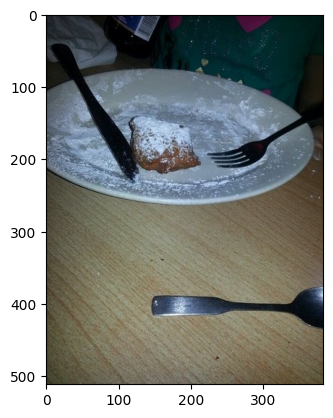

In [28]:
# Assuming the image is in the dataset and accessible as dataset[0]["image"]
# Replace 0 with the desired index if you want a different image
try:
    image = dataset[0]["image"].convert("RGB") # Remove Image.open(), directly convert to RGB
    plt.imshow(image)
    plt.show()
except Exception as e:
    print(f"Error displaying image: {e}")
    # Handle the error appropriately, e.g., check if the image file exists or if the image data is valid.

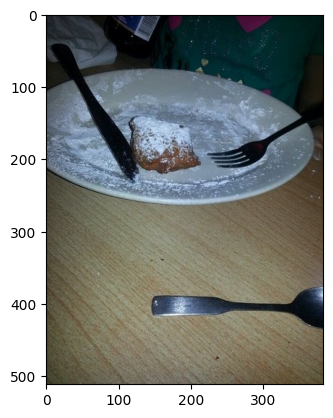

In [33]:
img = dataset[0]['image'].convert("RGB")
plt.imshow(img)
plt.show()

In [23]:
# prompt: show the image using PIL image

from PIL import Image
import matplotlib.pyplot as plt

# Assuming the image is in the dataset and accessible as dataset[0]["image"]
# Replace 0 with the desired index if you want a different image
try:
    image = Image.open(dataset[0]["image"].convert("RGB")) # Convert image to RGB
    plt.imshow(image)
    plt.show()
except Exception as e:
    print(f"Error displaying image: {e}")
    # Handle the error appropriately, e.g., check if the image file exists or if the image data is valid.



Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

In [ ]:
# prompt: generate a empty hungginface dataset object with the new_features

from datasets import Dataset, Features, Image, ClassLabel

# Assuming old_features is defined as in your original code
old_features = Features({'image': Image(decode=False), 'label': ClassLabel(num_classes=101, names=['apple_pie', 'baby_back_ribs', ...]),}) # Replace ... with actual class names

new_features = Features({
    **old_features,
    "augment_image": Image()  # 新增图像列
})

empty_dataset = Dataset.from_dict({
    "image": [],
    "label": [],
    "augment_image": []
}, features=new_features)

print(empty_dataset)
empty_dataset.features


In [13]:
print(old_features)

TypeError: 'image' is an invalid keyword argument for print()

In [16]:
# 数据集结构修改，加入增强图片
new_features = Features({
    ​**old_features,
    "augment_image": Image()  # 新增图像列
})

SyntaxError: invalid non-printable character U+200B (<ipython-input-16-c9bf670b627b>, line 3)

## Prepare datasets for training and evaluation

1. Prepare `label2id` and `id2label` dictionaries. This will come in handy when performing inference and for metadata information.

In [7]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'baklava'

2. We load the image processor of the model we're fine-tuning.

In [8]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

As one might notice, the `image_processor` has useful information on which size the training and evaluation images should be resized, stats that should be used to normalize the pixel values, etc.

3. Using the image processor we prepare transformation functions for the datasets. These functions will include augmentation and pixel scaling.  

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

4. We split our mini dataset into training and validation.

In [10]:
# split up training into training + validation
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [14]:
print(train_ds,val_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 450
}) Dataset({
    features: ['image', 'label'],
    num_rows: 50
})


5. We set the transformation functions to the datasets accordingly.

In [11]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## Load and prepare a model

In this section, we first load the model we want to fine-tune.

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

The `get_peft_model()` method that we will use in a moment wraps the original model to be fine-tuned as a `PeftModel`. So, it's important for us to initialize the original model correctly. As such, we initialize it by specifying the `label2id` and `id2label` so that `AutoModelForImageClassification` can initialize a append classification head to the underlying model, adapted for our dataset. We can confirm this from the warning below:

```
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
```

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


Also, take note of the number of total trainable parameters of `model`: it's 100%! We'll compare this number to that of the LoRA model.

We now use the `PeftModel` to wrap `model` so that the "update" matrices are added to the respective places.

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


Let's unpack what's going on here.

In order for LoRA to take effect, we need to specify the target modules to `LoraConfig` so that `get_peft_model()` knows which modules inside our model needs to be amended with LoRA matrices. In this case, we're only interested in targetting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" with `query` and `value` respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`.

We also specify `modules_to_save`. After we wrap our base model `model` with `get_peft_model()` along with the `config`, we get a new model where only the LoRA parameters are trainable (so-called "update matrices") while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.  

Regarding the other parameters:

* `r`: The dimension used by the LoRA update matrices.
* `alpha`: Scaling factor.
* `bias`: Specifying if the `bias` parameters should be trained. `None` denotes none of the `bias` parameters will be trained.

`r` and `alpha` together control the total number of final trainable parameters when using LoRA giving us the flexbility to balance a trade-off between end performance and compute efficiency.


We can also how many parameters we're actually training. Since we're interested in performing **parameter-efficient fine-tuning**, we should expect to notice a less number of trainable parameters from the `lora_model` in comparison to the original `model` which is indeed the case here.

## Training arguments

We will leverage [🤗 Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) for fine-tuning. It accepts several arguments which we wrap using [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [16]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

Some things to note here:

* We're using a larger batch size since there is only a handful of parameters to train.
* Larger learning rate than the normal (1e-5 for example).

All of these things are a byproduct of the fact that we're training only a small number of parameters. This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments.

## Prepare evaluation metric

In [17]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Collation function

This is used by `Trainer` to gather a batch of training and evaluation examples and prepare them in a format that is acceptable by the underlying model.

In [18]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Train and evaluate

In [19]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

<ipython-input-19-88a730ffb9df>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: typhoonninety (typhoonninety-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,4.005156,0.980000
2,No log,3.249531,1.000000
3,No log,2.499102,1.000000
4,No log,1.890566,1.000000
5,No log,1.581172,1.000000


In just a few minutes, we have a fine-tuned model with 96% validation accuracy. Also, note that we used a very small subset of the training dataset which is definitely impacting the results.

In [22]:
trainer.evaluate(val_ds)

{'eval_loss': 3.2495310306549072,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.4327,
 'eval_samples_per_second': 115.561,
 'eval_steps_per_second': 2.311,
 'epoch': 5.0}

## Sharing your model and inference

Once the fine-tuning is done, we can share the LoRA parameters with the community like so:

In [23]:
repo_name = f"sayakpaul/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)

HfHubHTTPError: (Request ID: Root=1-67d11c4b-7fcb882702739af9044f26cc;d9ccca3f-a36c-466a-8a8f-12d74e4f2587)

403 Forbidden: Authorization error..
Cannot access content at: https://huggingface.co/sayakpaul/vit-base-patch16-224-in21k-finetuned-lora-food101.git/info/lfs/objects/batch.
Make sure your token has the correct permissions.

When we call `push_to_hub()` on the `lora_model`, only the LoRA parameters along with any modules specified in `modules_to_save` are saved. If we take a look at the [trained LoRA parameters](https://huggingface.co/sayakpaul/vit-base-patch16-224-in21k-finetuned-lora-food101/blob/main/adapter_model.bin), we see that it's only **2.6 MB**! This greatly helps with portability especially when we're using a very large model to fine-tune (such as [BLOOM](https://huggingface.co/bigscience/bloom)).

Next, we see how to load the LoRA updated parameters along with our base model for inference. When we wrap a base model with `PeftModel` that modifications are DONE in place. So to mitigate any concerns that might stem from in place modifications, we newly initialize our base model just like we did earlier and construct our inference model.

In [29]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

adapter_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.bin:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Don't worry about the warnings, they're harmless.

Let's now fetch a sample for inference.

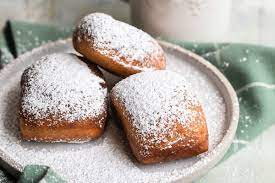

In [24]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

We first instantiate an `image_processor` from the underlying model repo.

In [25]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We then prepare the sample for inference.

In [26]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


And run inference!

In [31]:
import torch

# forward pass
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: beignets
